In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import logging
import jax
import jax.numpy as jnp

os.chdir("/Users/mark/Code/luas")

import pymc as pm
import arviz as az
import corner

from src.luas.GPyMCClass import GPyMC
from src.luas.sample_kernels import build_VLT_kernel, build_VLT_GeneralKernel
from src.luas.transit_functions import transit_2D, ld_to_kipping, transit_param_transform
from src.luas.kronecker_functions import *

logging.getLogger().setLevel(logging.INFO)
%load_ext autoreload
%autoreload 2


In [76]:
jax.__version__

'0.3.17'

Load in data and pre-computed limb darkening coefficients

In [2]:
data_save_name = f"WASP31b_FORS2_600B"
data_folder = os.path.join("sample_data", data_save_name)

x_l = np.load(os.path.join(data_folder, f"x_l.npy"))
x_t = np.load(os.path.join(data_folder, f"x_t.npy"))
Y = np.load(os.path.join(data_folder, f"Y.npy"))
ld_coeff = np.load(os.path.join(data_folder, f"ld_coeff.npy"))
ld_coeff_errs = 0.01*np.ones((x_l.size, 2))

# Convert limb darkening coefficients to Kipping transformed parameters q1, q2
q1, q2 = ld_to_kipping(ld_coeff[:, 0], ld_coeff[:, 1])

N_l = x_l.size
N_t = x_t.size

x_l = jax.device_put(x_l)
x_t = jax.device_put(x_t)
Y = jax.device_put(Y)

INFO:absl:Remote TPU is not linked into jax; skipping remote TPU.
INFO:absl:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:absl:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


Define initial parameters, kernel function, priors, parameters to fit for and then build GPyMC object

Note: Save location unspecified, defaulting to '/analyses/default_loc/121849_11_09_23_355'
Note: Filename suffix unspecified, defaulting to '76829682'
Starting logL:  23203.75738112267


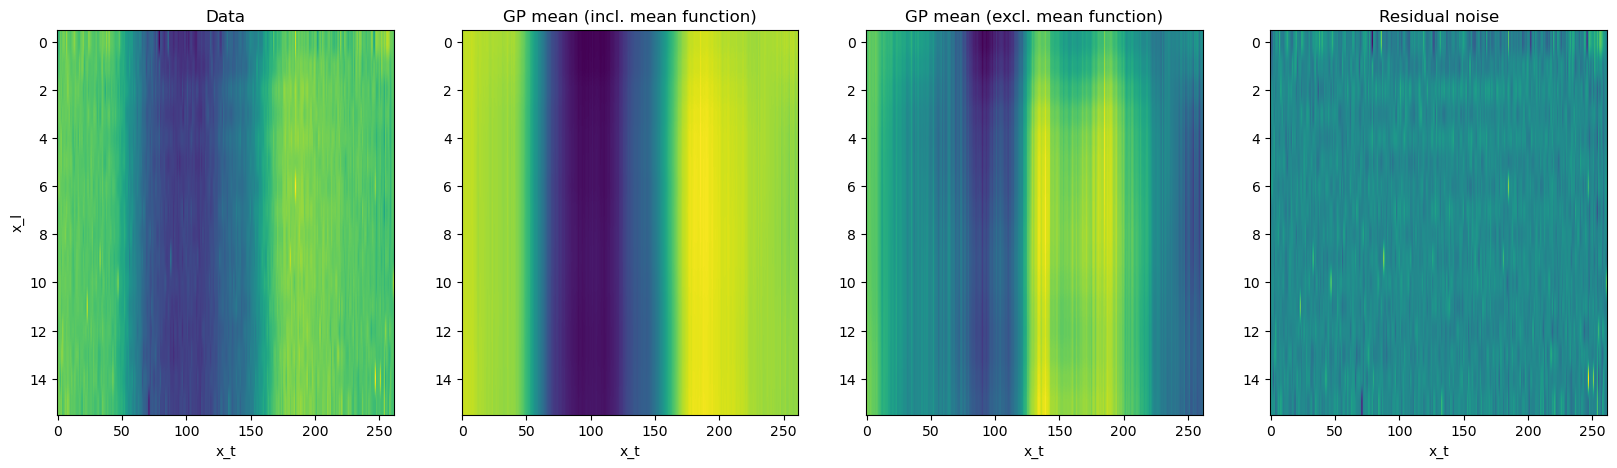

In [83]:
# Specify initial parameters to use as starting point for optimisation
initial_params = {"T0":-0.0021*np.ones(1), "P":3.4059095*np.ones(1), "a":8.19*np.ones(1), "b":0.761*np.ones(1), "rho_2":0.12546**2*np.ones(N_l),
                  "c1":q1, "c2":q2, "Foot":np.ones(N_l)*0.9995, "Tgrad":np.ones(N_l)*0.0002,
                  "h_CM":1.5e-3*np.ones(1), "l_t":0.011*np.ones(1), "l_l_CM":10000*np.ones(1), "sigma":1.2e-3*np.ones(N_l),
                  "h_WSS":2e-4*np.ones(N_l), "h_HFS":3e-4*np.ones(1), "l_l_HFS":1000*np.ones(1), "l_t_WSS":0.01, "l_l_WSS":300.}

# Choose the kernel previously used for fitting VLT data (imported from sample_kernels)
# VLT_kernel = build_VLT_kernel()
VLT_kernel = build_VLT_GeneralKernel()

# Specify Gaussian priors on some parameters
prior_values = {"a":8.19, "b":0.761}
prior_std = {"a":0.1, "b":0.018}

prior_dict = {"a":[prior_values["a"], prior_std["a"]], "b":[prior_values["b"], prior_std["b"]],
              "c1":[ld_coeff[:, 0], ld_coeff_errs[:, 0]], "c2":[ld_coeff[:, 1], ld_coeff_errs[:, 1]]}


# Specify bounds on parameters for use with PyMC
param_bounds = {"T0":[np.array([-0.01]), np.array([0.01])],
                "rho_2":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "sigma":[np.array([1e-5]*N_l), np.array([1e-2]*N_l)],
                "Foot":[np.array([0.99]*N_l), np.array([1.01]*N_l)],
                "Tgrad":[np.array([-0.1]*N_l), np.array([0.1]*N_l)],
                "c1":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "c2":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "h_WSS":[np.array([1e-6]*N_l), np.array([1e-2]*N_l)],
                "h_CM":[np.array([1e-6]*1), np.array([1e-2]*1)],
                "l_t":[np.array([np.diff(x_t).min()]), np.array([2*(x_t.max() - x_t.min())])],
                "l_l_CM":[np.array([np.diff(x_l).min()]), np.array([50*(x_l.max() - x_l.min())])],
                "h_HFS":[np.array([1e-6]), np.array([1e-2])],
                "l_l_HFS":[np.array([np.diff(x_l).min()]), np.array([50*(x_l.max() - x_l.min())])],
                "l_t_WSS":[np.array([np.diff(x_t).min()]), np.array([2*(x_t.max() - x_t.min())])],
                "l_l_WSS":[np.array([np.diff(x_l).min()]), np.array([50*(x_l.max() - x_l.min())])]}

# Specify parameters to vary for inference
mfp_to_vary = ["T0", "a", "b", "c1", "c2", "rho_2", "Foot", "Tgrad"]         # Mean function parameters
hp_to_vary = ["h_CM", "l_l_CM", "l_t", "h_WSS", "h_HFS", "l_l_HFS", "sigma", "l_t_WSS", "l_l_WSS"] # Hyperparameters

# Specify parameters to use log priors on
log_params = ["h_CM", "l_t", "l_l_CM", "sigma", "h_WSS", "h_HFS", "l_l_HFS", "l_t_WSS", "l_l_WSS"]

# Convert starting values and parameter bounds to log values
for name in log_params:
    initial_params[name] = np.log10(initial_params[name])
    param_bounds[name][0] = np.log10(param_bounds[name][0])
    param_bounds[name][1] = np.log10(param_bounds[name][1])

    
# Define GP object
gp = GPyMC(initial_params, mfp_to_vary, hp_to_vary, x_l, x_t, Y, VLT_kernel,
       mf = transit_2D, log_params = log_params, transform_fn = transit_param_transform,
        gaussian_prior_dict = prior_dict, param_bounds = param_bounds)


print("Starting logL: ", gp.logL(gp.p))
gp.plot(gp.p)

Optimise, clip 4 sigma outliers and optimise again

In [19]:
gp.p_opt = gp.optimise()

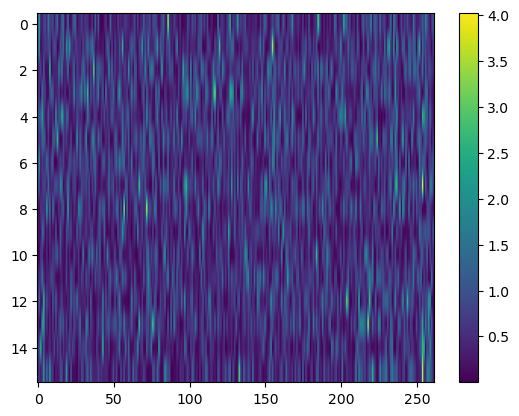

Outliers removed =  1


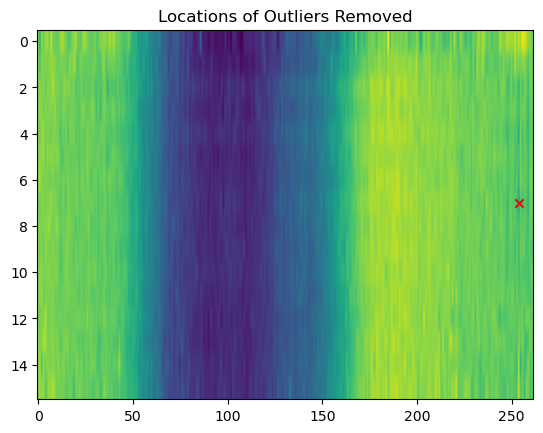

In [50]:
gp_load.Y = gp_load.clip_outliers(gp_load.p, 4.)

In [21]:
gp.p = gp.optimise()

In [37]:
jnp.sqrt(cov_mat["l_t_WSS"]["l_t_WSS"]), jnp.sqrt(cov_mat["l_t"]["l_t"])

(DeviceArray([[0.07069359]], dtype=float64),
 DeviceArray([[0.05480282]], dtype=float64))

Save optimised GP state to avoid needing to rerun

In [41]:
gp.save()
# gp.logP(gp.p)

Saved GP state at:  analyses/default_loc/181153_08_09_23_374/GP_save_28774383.pkl


In [43]:
gp.logP(gp.p_opt)

DeviceArray(24628.87731095, dtype=float64)

In [51]:
from src.luas.GPyMCClass import GPyMC_from_file

gp_load = GPyMC_from_file("analyses/default_loc/181153_08_09_23_374", "GP_save_28774383.pkl", build_VLT_GeneralKernel(),
                mf = transit_2D, transform_fn = transit_param_transform)
gp_load.logP(gp_load.p)

Note: Filename suffix unspecified, defaulting to '76697972'


DeviceArray(24628.87731095, dtype=float64)

In [53]:
gp_load.p = gp_load.optimise()

In [56]:
print(gp_load.logP(gp_load.p))
gp_load.save()

24709.699954656582
Saved GP state at:  analyses/default_loc/181153_08_09_23_374/GP_save_76697972.pkl


May want to change parameters being fit for in MCMC so redefine a new object here

In [73]:
gp2 = GPyMC_from_file("analyses/default_loc/181153_08_09_23_374", "GP_save_80668031.pkl", build_VLT_GeneralKernel(),
                mf = transit_2D, transform_fn = transit_param_transform)
gp2.logP(gp2.p)

Note: Filename suffix unspecified, defaulting to '30104113'


DeviceArray(24709.69995466, dtype=float64)

In [59]:
hess = gp2.hessian_logP(gp2.p, large = True)
cov_dict = gp2.hessian_to_covariance_mat(hess)

100%|█████████████████████████████████████████████████████████████| 24/24 [17:00<00:00, 42.52s/it]


In [69]:
cov_dict_reg = gp2.hessian_to_covariance_mat(hess, regularise = True)

In [72]:
gp2.save()

Saved GP state at:  analyses/default_loc/181153_08_09_23_374/GP_save_80668031.pkl


In [ ]:
# New parameters to fit for
# mfp_to_vary = ["T0", "c1", "c2", "a", "b", "rho_2", "Foot", "Tgrad"]
# hp_to_vary = ["h_CM", "l_t", "h_HFS", "l_l_HFS", "sigma", "l_l_CM", "h_WSS"]

# Define optimised initial parameters including the fixed parameters which were not optimised
opt_params = deepcopy(initial_params)
opt_params.update(gp_load.p)

gp2 = GPyMC(opt_params, mfp_to_vary, hp_to_vary, x_l, x_t, gp.Y, VLT_kernel,
       log_params = log_params, eigen_fn = eigendecomp_no_checks_jittable,
        mf = transit_2D, gaussian_prior_dict = prior_dict, param_bounds = param_bounds) #eigendecomp_rakitsch_general) #eigendecomp_no_checks_jittable)

print(gp2.logP(gp2.p))

In [70]:
gp2.cov_dict = cov_dict_reg

In [79]:
%timeit gp2.value_and_grad_logP(gp2.p)/

1.93 s ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
gp2.run_NUTS(tune = 100, draws = 100, chains = 1, slice_sample = [], large = True, regularise = True)

100%|█████████████████████████████████████████████████████████████| 24/24 [17:32<00:00, 43.85s/it]
INFO:pymc:Sequential sampling (1 chains in 1 job)
INFO:pymc:NUTS: [T0, a, b, c1, c2, rho_2, Foot, Tgrad, h_CM, l_l_CM, l_t, h_WSS, h_HFS, l_l_HFS, sigma, l_t_WSS, l_l_WSS]


/Users/mark/miniforge3/envs/pymc4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mark/miniforge3/envs/pymc4/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:pymc:Sampling 1 chain for 38 tune and 0 draw iterations (38 + 0 draws total) took 5387 seconds.


False

In [ ]:
df_summary_2D = gp2.summary()

In [ ]:
gp2.plot_corner(params = ["h_WSS"], dims = [3, 5, 12])

In [ ]:
gp2.save_folder

In [ ]:
gp2 = GPyMC_from_file("analyses/default_loc/135307_17_08_23_719", "GP_save_4682259.pkl", build_VLT_kernel(),
                mf = transit_2D, eigen_fn = eigendecomp_no_checks_jittable, jit_fn = True)

df_summary_2D = gp2.summary(show = False)
h_WSS_mask = df_summary_2D.loc[[f"h_WSS[{i}]" for i in range(N_l)], "ess_tail"].to_numpy() < 100

print(h_WSS_mask)

In [ ]:
gp3 = gp2.param_split(gp2.p, ["h_WSS"], [h_WSS_mask], eigen_fn = eigendecomp_Kl_checks_jittable, jit_fn = True)
gp3.logP(gp3.p)

In [ ]:
gp3.run_NUTS(tune = 1000, draws = 1000, chains = 2, slice_sample = ["h_WSS1"])